In [49]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [50]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [51]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="Z:/ArtGenerator/Resized_color256x512",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

952


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


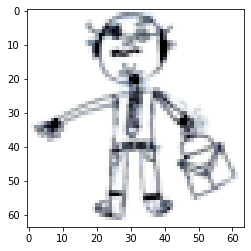

In [52]:
images,_ = train_ds[3]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


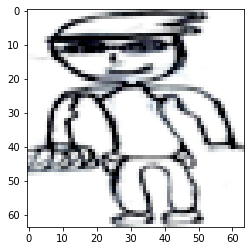

In [53]:
images,_ = train_ds[8]
plt.imshow(images.permute(1,2,0))

In [54]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [55]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

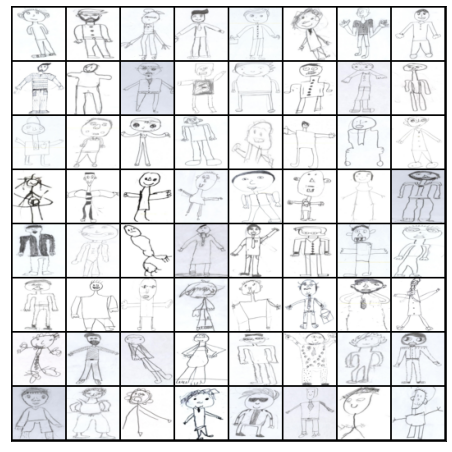

In [56]:
show_batch(train_dl)

In [57]:
torch.cuda.is_available()

True

In [58]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
device = get_default_device()
device

device(type='cuda')

In [60]:
train_dl = DeviceDataLoader(train_dl, device)

In [61]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [62]:
discriminator = to_device(discriminator, device)

In [63]:
latent_size = 150

In [64]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Defining the model

torch.Size([128, 3, 64, 64])


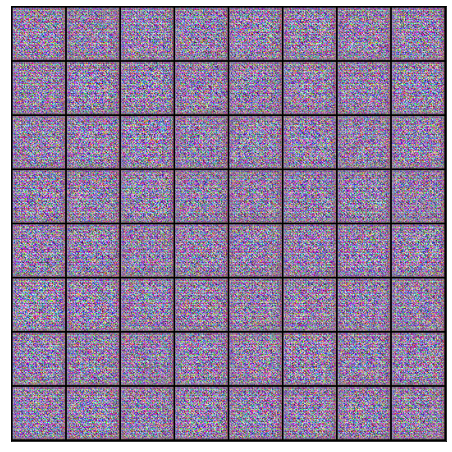

In [65]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [66]:
generator = to_device(generator, device)

In [67]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [68]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [69]:
from torchvision.utils import save_image

In [70]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [71]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [72]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


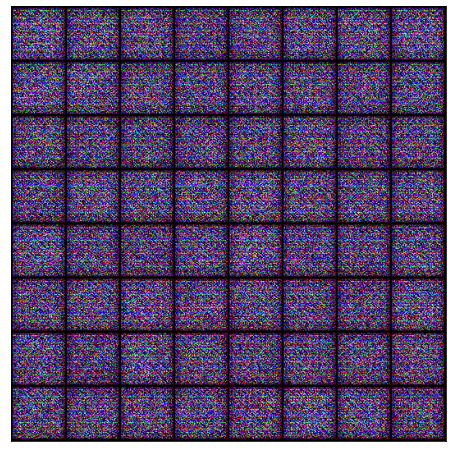

In [73]:
save_samples(0, fixed_latent)

In [74]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [75]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [76]:
lr = 0.001
epochs = 150

In [77]:
history = fit(epochs,lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 11.8217, loss_d: 0.1643, real_score: 0.8798, fake_score: 0.0001
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 8.1992, loss_d: 0.4448, real_score: 0.9989, fake_score: 0.3320
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 10.1583, loss_d: 4.8906, real_score: 0.9999, fake_score: 0.9070
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 6.8769, loss_d: 1.7402, real_score: 0.9163, fake_score: 0.7551
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 2.2327, loss_d: 3.3789, real_score: 0.0801, fake_score: 0.0282
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 5.2221, loss_d: 1.0013, real_score: 0.9763, fake_score: 0.5945
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 3.0495, loss_d: 4.9513, real_score: 0.0136, fake_score: 0.0107
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 1.5644, loss_d: 0.7371, real_score: 0.7886, fake_score: 0.3846
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 2.8872, loss_d: 0.2243, real_score: 0.9220, fake_score: 0.1302
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 2.0615, loss_d: 0.4258, real_score: 0.8537, fake_score: 0.2040
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 0.6893, loss_d: 0.7526, real_score: 0.6172, fake_score: 0.0579
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 2.2308, loss_d: 0.7607, real_score: 0.6131, fake_score: 0.1523
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 2.3670, loss_d: 0.8332, real_score: 0.6081, fake_score: 0.2191
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 4.6406, loss_d: 0.8345, real_score: 0.8654, fake_score: 0.4575
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 3.4679, loss_d: 0.8658, real_score: 0.8244, fake_score: 0.4429
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 1.4425, loss_d: 0.8763, real_score: 0.9032, fake_score: 0.5219
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 7.4851, loss_d: 0.7229, real_score: 0.8197, fake_score: 0.3356
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 2.5752, loss_d: 0.6116, real_score: 0.9384, fake_score: 0.4066
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 2.4919, loss_d: 0.5901, real_score: 0.9925, fake_score: 0.4258
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 2.5706, loss_d: 0.5975, real_score: 0.9235, fake_score: 0.3885
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 2.4374, loss_d: 0.1305, real_score: 0.9634, fake_score: 0.0842
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 4.8698, loss_d: 0.6532, real_score: 0.8916, fake_score: 0.3817
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 3.6469, loss_d: 0.3519, real_score: 0.9198, fake_score: 0.2096
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 4.0708, loss_d: 0.2703, real_score: 0.8632, fake_score: 0.0745
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 2.3930, loss_d: 0.3900, real_score: 0.9531, fake_score: 0.2622
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 4.8836, loss_d: 0.3026, real_score: 0.7839, fake_score: 0.0187
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 2.6157, loss_d: 2.4267, real_score: 0.1398, fake_score: 0.0021
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 4.1865, loss_d: 0.4975, real_score: 0.7461, fake_score: 0.1154
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 3.9113, loss_d: 1.5841, real_score: 0.9119, fake_score: 0.7061
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 5.0295, loss_d: 0.4948, real_score: 0.9091, fake_score: 0.2934
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 4.7932, loss_d: 0.8399, real_score: 0.7626, fake_score: 0.3353
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 6.1942, loss_d: 0.6781, real_score: 0.9851, fake_score: 0.4495
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 5.1174, loss_d: 1.8200, real_score: 0.9943, fake_score: 0.7802
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 4.3244, loss_d: 0.4469, real_score: 0.9302, fake_score: 0.2863
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 6.4544, loss_d: 0.7422, real_score: 0.9607, fake_score: 0.4610
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 1.8395, loss_d: 0.5767, real_score: 0.8044, fake_score: 0.2374
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 6.1838, loss_d: 0.5942, real_score: 0.8241, fake_score: 0.2617
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 5.2040, loss_d: 1.3635, real_score: 0.8911, fake_score: 0.6378
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 2.2344, loss_d: 0.5211, real_score: 0.8557, fake_score: 0.2503
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 9.8374, loss_d: 1.6871, real_score: 0.9740, fake_score: 0.7075
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 4.3771, loss_d: 0.8431, real_score: 0.8994, fake_score: 0.4493
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 8.6084, loss_d: 0.9511, real_score: 0.9375, fake_score: 0.5152
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 2.4181, loss_d: 1.0195, real_score: 0.6676, fake_score: 0.2905
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 3.6828, loss_d: 0.5332, real_score: 0.7040, fake_score: 0.0900
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.2250, loss_d: 0.5044, real_score: 0.9079, fake_score: 0.3074
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 3.1477, loss_d: 0.3977, real_score: 0.7915, fake_score: 0.0923
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 7.0234, loss_d: 0.6939, real_score: 0.9259, fake_score: 0.4189
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 6.5285, loss_d: 1.3010, real_score: 0.9243, fake_score: 0.6255
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 5.3055, loss_d: 0.7948, real_score: 0.8677, fake_score: 0.4200
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 4.6355, loss_d: 0.4542, real_score: 0.7801, fake_score: 0.0592
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 4.5768, loss_d: 0.3394, real_score: 0.8788, fake_score: 0.1617
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 3.9365, loss_d: 0.5385, real_score: 0.7452, fake_score: 0.1151
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 3.0441, loss_d: 0.4157, real_score: 0.8031, fake_score: 0.1399
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 2.9736, loss_d: 1.1348, real_score: 0.4459, fake_score: 0.0549
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 4.2675, loss_d: 0.5208, real_score: 0.7353, fake_score: 0.1225
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 5.9838, loss_d: 0.8074, real_score: 0.8777, fake_score: 0.4462
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 5.9378, loss_d: 1.5155, real_score: 0.9407, fake_score: 0.6806
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 3.7487, loss_d: 0.8557, real_score: 0.6908, fake_score: 0.3071
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 2.5445, loss_d: 2.0052, real_score: 0.2361, fake_score: 0.0064
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 1.7296, loss_d: 0.6307, real_score: 0.7213, fake_score: 0.1955
Saving generated-images-0060.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 3.0889, loss_d: 0.8960, real_score: 0.5378, fake_score: 0.0732
Saving generated-images-0061.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 3.9498, loss_d: 0.4754, real_score: 0.7622, fake_score: 0.1404
Saving generated-images-0062.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 4.0943, loss_d: 0.5199, real_score: 0.8036, fake_score: 0.2067
Saving generated-images-0063.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 4.2306, loss_d: 1.1225, real_score: 0.4129, fake_score: 0.0167
Saving generated-images-0064.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 6.6086, loss_d: 0.6802, real_score: 0.8859, fake_score: 0.3937
Saving generated-images-0065.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 2.3036, loss_d: 0.6138, real_score: 0.7229, fake_score: 0.1847
Saving generated-images-0066.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 4.5735, loss_d: 1.3046, real_score: 0.9284, fake_score: 0.6579
Saving generated-images-0067.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 3.1570, loss_d: 0.7883, real_score: 0.6482, fake_score: 0.1858
Saving generated-images-0068.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 3.1993, loss_d: 0.6196, real_score: 0.8353, fake_score: 0.2869
Saving generated-images-0069.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 6.1843, loss_d: 1.0429, real_score: 0.7791, fake_score: 0.4762
Saving generated-images-0070.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 6.2236, loss_d: 0.4588, real_score: 0.8953, fake_score: 0.2752
Saving generated-images-0071.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 4.4629, loss_d: 0.9050, real_score: 0.8545, fake_score: 0.4895
Saving generated-images-0072.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 5.7387, loss_d: 0.9881, real_score: 0.7746, fake_score: 0.4529
Saving generated-images-0073.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 4.4825, loss_d: 0.5888, real_score: 0.6333, fake_score: 0.0244
Saving generated-images-0074.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 2.3826, loss_d: 1.1855, real_score: 0.3957, fake_score: 0.0136
Saving generated-images-0075.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 2.6333, loss_d: 0.9998, real_score: 0.4836, fake_score: 0.0870
Saving generated-images-0076.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 5.3392, loss_d: 0.8822, real_score: 0.8701, fake_score: 0.4778
Saving generated-images-0077.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 3.6778, loss_d: 0.5926, real_score: 0.7199, fake_score: 0.1629
Saving generated-images-0078.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 3.6387, loss_d: 0.4117, real_score: 0.7658, fake_score: 0.0908
Saving generated-images-0079.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 4.3461, loss_d: 1.6716, real_score: 0.2844, fake_score: 0.0021
Saving generated-images-0080.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 5.6341, loss_d: 1.1674, real_score: 0.9345, fake_score: 0.5874
Saving generated-images-0081.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 5.5649, loss_d: 0.4906, real_score: 0.8744, fake_score: 0.2731
Saving generated-images-0082.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 5.4108, loss_d: 1.0614, real_score: 0.8432, fake_score: 0.5087
Saving generated-images-0083.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 3.9370, loss_d: 0.6789, real_score: 0.7280, fake_score: 0.2287
Saving generated-images-0084.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 5.5851, loss_d: 0.5670, real_score: 0.6426, fake_score: 0.0126
Saving generated-images-0085.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 2.2651, loss_d: 0.2290, real_score: 0.8513, fake_score: 0.0448
Saving generated-images-0086.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 3.8924, loss_d: 0.2436, real_score: 0.8936, fake_score: 0.1088
Saving generated-images-0087.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 4.4702, loss_d: 0.5742, real_score: 0.9560, fake_score: 0.3418
Saving generated-images-0088.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 6.4126, loss_d: 0.7355, real_score: 0.9470, fake_score: 0.4439
Saving generated-images-0089.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 5.7599, loss_d: 0.5202, real_score: 0.8801, fake_score: 0.2799
Saving generated-images-0090.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 4.6565, loss_d: 0.4104, real_score: 0.8426, fake_score: 0.1850
Saving generated-images-0091.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 5.8102, loss_d: 0.5011, real_score: 0.9411, fake_score: 0.3151
Saving generated-images-0092.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 3.1643, loss_d: 0.5320, real_score: 0.7015, fake_score: 0.0741
Saving generated-images-0093.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 4.3069, loss_d: 0.4172, real_score: 0.7607, fake_score: 0.0518
Saving generated-images-0094.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 2.1021, loss_d: 0.3974, real_score: 0.8981, fake_score: 0.1919
Saving generated-images-0095.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 3.5242, loss_d: 0.5053, real_score: 0.7094, fake_score: 0.0766
Saving generated-images-0096.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 4.3859, loss_d: 0.4842, real_score: 0.7861, fake_score: 0.1530
Saving generated-images-0097.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 12.8194, loss_d: 1.3281, real_score: 0.9707, fake_score: 0.6679
Saving generated-images-0098.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 3.2275, loss_d: 0.3752, real_score: 0.8161, fake_score: 0.1354
Saving generated-images-0099.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 4.6250, loss_d: 0.5323, real_score: 0.9398, fake_score: 0.3340
Saving generated-images-0100.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 6.0064, loss_d: 0.6929, real_score: 0.9086, fake_score: 0.3763
Saving generated-images-0101.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 3.8251, loss_d: 0.4460, real_score: 0.7875, fake_score: 0.1335
Saving generated-images-0102.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 2.3697, loss_d: 0.5642, real_score: 0.7148, fake_score: 0.1279
Saving generated-images-0103.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 3.0147, loss_d: 0.7495, real_score: 0.6520, fake_score: 0.1674
Saving generated-images-0104.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 4.6245, loss_d: 0.4882, real_score: 0.7346, fake_score: 0.0507
Saving generated-images-0105.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 2.5220, loss_d: 0.5500, real_score: 0.7225, fake_score: 0.1392
Saving generated-images-0106.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 4.8929, loss_d: 0.3020, real_score: 0.8174, fake_score: 0.0608
Saving generated-images-0107.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 5.4688, loss_d: 0.8457, real_score: 0.9346, fake_score: 0.4859
Saving generated-images-0108.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 5.0480, loss_d: 0.6585, real_score: 0.8766, fake_score: 0.3716
Saving generated-images-0109.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 5.9106, loss_d: 2.1419, real_score: 0.1954, fake_score: 0.0008
Saving generated-images-0110.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 6.4001, loss_d: 0.7884, real_score: 0.8403, fake_score: 0.3859
Saving generated-images-0111.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 3.8439, loss_d: 0.3664, real_score: 0.9020, fake_score: 0.2090
Saving generated-images-0112.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 6.8024, loss_d: 0.2638, real_score: 0.8124, fake_score: 0.0190
Saving generated-images-0113.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 5.3329, loss_d: 0.4211, real_score: 0.9722, fake_score: 0.2841
Saving generated-images-0114.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 4.1244, loss_d: 0.3842, real_score: 0.7954, fake_score: 0.1029
Saving generated-images-0115.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 3.1286, loss_d: 0.4691, real_score: 0.8332, fake_score: 0.1803
Saving generated-images-0116.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 4.5363, loss_d: 0.4391, real_score: 0.8011, fake_score: 0.1539
Saving generated-images-0117.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 8.6046, loss_d: 0.8926, real_score: 0.9640, fake_score: 0.5055
Saving generated-images-0118.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 4.5056, loss_d: 0.9949, real_score: 0.4465, fake_score: 0.0039
Saving generated-images-0119.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 4.3612, loss_d: 0.8287, real_score: 0.5910, fake_score: 0.0147
Saving generated-images-0120.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 5.9784, loss_d: 0.5267, real_score: 0.9698, fake_score: 0.3507
Saving generated-images-0121.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 3.9330, loss_d: 0.5510, real_score: 0.6598, fake_score: 0.0629
Saving generated-images-0122.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 8.4284, loss_d: 0.6669, real_score: 0.9196, fake_score: 0.3776
Saving generated-images-0123.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 6.2203, loss_d: 0.4396, real_score: 0.9797, fake_score: 0.2771
Saving generated-images-0124.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 6.1757, loss_d: 0.5801, real_score: 0.8495, fake_score: 0.2986
Saving generated-images-0125.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 3.2422, loss_d: 2.6383, real_score: 0.1332, fake_score: 0.0004
Saving generated-images-0126.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 6.9716, loss_d: 0.6874, real_score: 0.8447, fake_score: 0.3485
Saving generated-images-0127.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 5.5067, loss_d: 0.2859, real_score: 0.8738, fake_score: 0.1066
Saving generated-images-0128.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 4.9577, loss_d: 0.4644, real_score: 0.9576, fake_score: 0.3008
Saving generated-images-0129.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 4.2547, loss_d: 0.6780, real_score: 0.5906, fake_score: 0.0047
Saving generated-images-0130.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 3.4627, loss_d: 0.3182, real_score: 0.9163, fake_score: 0.1690
Saving generated-images-0131.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 8.8068, loss_d: 0.4971, real_score: 0.9280, fake_score: 0.3025
Saving generated-images-0132.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 7.7864, loss_d: 0.7911, real_score: 0.9212, fake_score: 0.4510
Saving generated-images-0133.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 4.0645, loss_d: 0.2046, real_score: 0.8998, fake_score: 0.0780
Saving generated-images-0134.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 4.3486, loss_d: 0.1712, real_score: 0.8828, fake_score: 0.0314
Saving generated-images-0135.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 3.7991, loss_d: 0.5348, real_score: 0.6494, fake_score: 0.0311
Saving generated-images-0136.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 8.6775, loss_d: 0.6366, real_score: 0.9591, fake_score: 0.3989
Saving generated-images-0137.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 6.1815, loss_d: 0.4958, real_score: 0.6806, fake_score: 0.0074
Saving generated-images-0138.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 4.6419, loss_d: 0.2390, real_score: 0.8660, fake_score: 0.0689
Saving generated-images-0139.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 10.2065, loss_d: 6.4454, real_score: 0.0156, fake_score: 0.0000
Saving generated-images-0140.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 4.9091, loss_d: 0.6339, real_score: 0.9252, fake_score: 0.3759
Saving generated-images-0141.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 5.6295, loss_d: 0.5386, real_score: 0.8016, fake_score: 0.1903
Saving generated-images-0142.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 4.1470, loss_d: 0.3082, real_score: 0.8671, fake_score: 0.1141
Saving generated-images-0143.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 8.4197, loss_d: 0.7054, real_score: 0.9623, fake_score: 0.4133
Saving generated-images-0144.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 4.8375, loss_d: 0.3254, real_score: 0.9494, fake_score: 0.2024
Saving generated-images-0145.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 4.6323, loss_d: 0.2339, real_score: 0.8876, fake_score: 0.0875
Saving generated-images-0146.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 7.4261, loss_d: 0.5239, real_score: 0.9906, fake_score: 0.3510
Saving generated-images-0147.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 6.2219, loss_d: 0.2376, real_score: 0.9354, fake_score: 0.1352
Saving generated-images-0148.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 5.2828, loss_d: 0.8480, real_score: 0.5842, fake_score: 0.0062
Saving generated-images-0149.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 6.9252, loss_d: 0.3575, real_score: 0.9101, fake_score: 0.1999
Saving generated-images-0150.png


In [78]:
from IPython.display import Image 

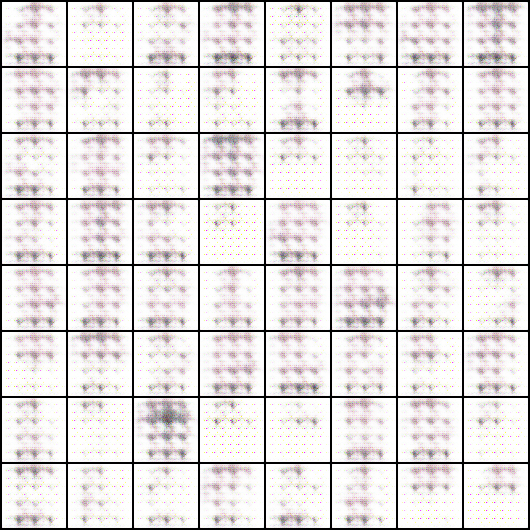

In [79]:
Image('./generated/generated-images-0013.png')

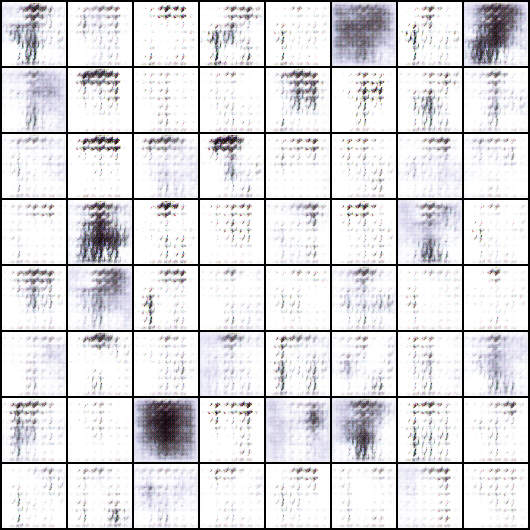

In [80]:
Image('./generated/generated-images-0037.png')

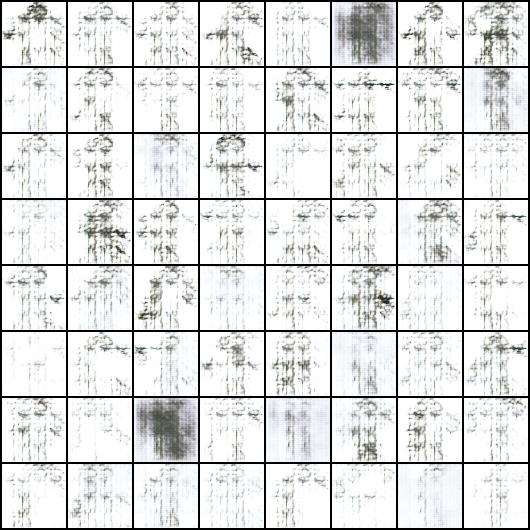

In [81]:
Image('./generated/generated-images-0072.png')

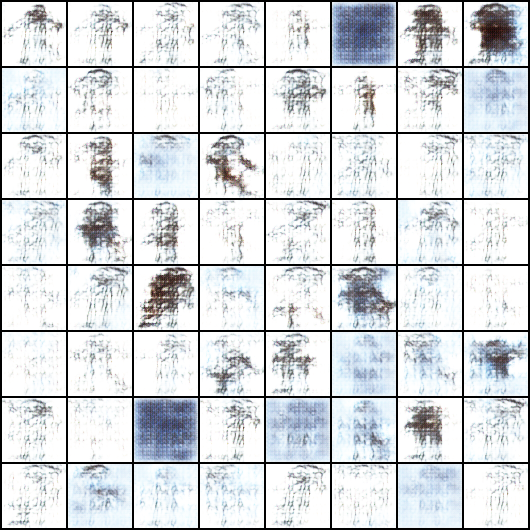

In [82]:
Image('./generated/generated-images-0103.png')

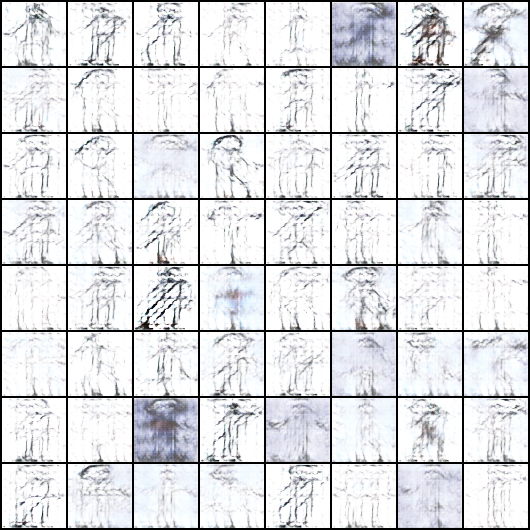

In [83]:
Image('./generated/generated-images-0138.png')

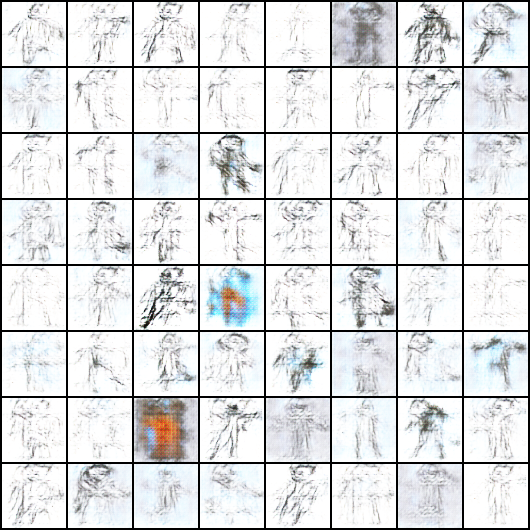

In [84]:
Image('./generated/generated-images-0147.png')

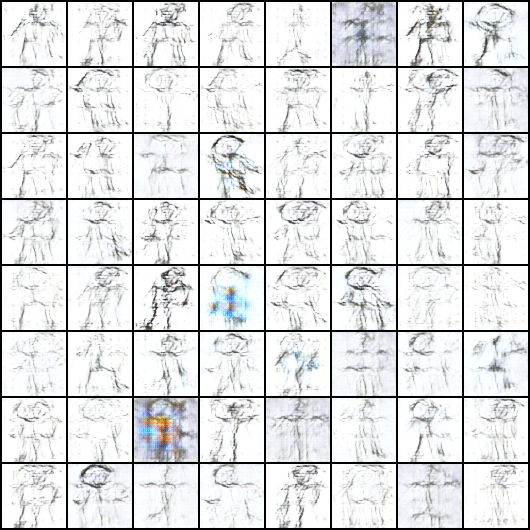

In [85]:
Image('./generated/generated-images-0150.png')

In [86]:
losses_g, losses_d, real_scores, fake_scores = history

In [87]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

NameError: name 'jovian' is not defined

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()